https://github.com/henrhoi/gan-pytorch/blob/master/non_saturating_gan_1d.py
https://github.com/shayneobrien/generative-models/blob/master/src/ns_gan.py

<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2023</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 2 - Part 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
        <font size=3>TA: <a href="mailto:alirezaghafouri@ut.ac.ir">Alireza Ghafouri</a><br></font><br>
        
    </div>
</div>

# Working with GANs using PyTorch

This notebook is a homework assignment for the Deep Generative Models course at the University of Tehran. The goal of this assignment is to get familiar with the concept of Generative Adversarial Networks (GANs) and how to implement it with PyTorch. We will use the MNIST dataset for this assignment.

---


**Requisites**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---

In [ ]:
!free -m
!df -h
!nvidia-smi

               total        used        free      shared  buff/cache   available
Mem:           12982         527       10005           1        2448       12178
Swap:              0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   27G   52G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  885M  55% /usr/sbin/docker-init
tmpfs           6.4G   44K  6.4G   1% /var/colab
/dev/sda1        50G   30G   21G  59% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Tue Dec 12 04:26:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persisten

# **Import Libraries:**

Import your required libraries!

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch import autograd
import torch.optim as optim
import torchvision.utils as vutils
from torch.nn import functional as F
import torchvision.datasets as datasets
from torchvision.utils import save_image
import torchvision.transforms as transforms

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1)

## **Downloading the dataset:**

We will use the MNIST dataset for this assignment. The dataset is already available in PyTorch, so we just need to download it.

In [ ]:
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=True, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=False, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )

# # Create pre-processed training and test sets
# X_train = train_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
# y_train = train_loader.dataset.data.to(device)
# X_test = test_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
# y_test = test_loader.dataset.data.to(device)

# print('Train dataset shape: ', X_train.data.shape)
# print('Test dataset shape: ', y_train.data.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 115386162.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11192432.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26761696.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9814801.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)


class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))

## **Define Generator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [ ]:

class Generator(torch.nn.Module):
    def __init__(self, z_dim=64, num_channels=1):
        super().__init__()
        self.z_dim = z_dim

        ############################# TODO #############################
        # Complete this part according to the introduced generator table on the provided manuscript!
        # YOUR CODE STARTS HERE
        self.fc1 = nn.Linear(64, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 3136)
        self.bn2 = nn.BatchNorm1d(3136)

        self.reshape = Reshape(64, 7, 7)
        self.relu = ReLU()

        self.pixelshuffle2 = nn.PixelShuffle(2)

        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(3,3), padding=1)

        # YOUR CODE ENDS HERE


    def forward(self, z):

        z = self.fc1(z)
        z = self.bn1(z)
        z = self.relu(z)

        z = self.fc2(z)
        z = self.bn2(z)
        z = self.relu(z)

        z = self.reshape(z)
        z = self.pixelshuffle2(z)

        z = self.conv1(z)
        z = self.bn3(z)
        z = self.relu(z)

        z = self.pixelshuffle2(z)
        z = self.conv2(z)

        return z

## **Define Discriminator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()

        ############################# TODO #############################
        # Complete this part according to the introduced discriminator table on the provided manuscript!

        # YOUR CODE STARTS HERE
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4), padding=1, stride=2)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, 1)

        self.relu = ReLU()
        self.reshape = Reshape(1, 28, 28)
        self.reshapeFC = Reshape(3136)
        # YOUR CODE ENDS HERE


    def forward(self, x):

        x = self.reshape(x)
        # print(x.shape)

        x = self.conv1(x)
        x = self.relu(x)
        # print(x.shape)

        x = self.conv2(x)
        x = self.relu(x)
        # print(x.shape)

        x = self.reshapeFC(x)
        x = self.fc1(x)

        x = self.fc2(x)

        return torch.sigmoid(x)

## **Define Your GAN:**

In [ ]:
class GAN(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()   # note that discriminator outputs logits
        self.log = nn.LogSigmoid()

    def loss_nonsaturating(self, x_real, discriminator, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): nonsaturating discriminator loss
        - g_loss (torch.Tensor): nonsaturating generator loss
        '''

        ############################# TODO #############################
        # YOUR CODE STARTS HERE
        D_loss = 0
        G_loss = 0

        # Sample noise z, generate output G(z)
        noise = torch.randn(x_real.shape[0], self.z_dim).to(device)
        G_output = self.g(noise)
        DG_score = self.d(G_output) # D(G(z))

        if discriminator:
            DX_score = self.d(x_real) # D(x)
            # print(DX_score)
            # Compute D loss
            D_loss = -torch.mean(torch.log(DX_score + 1e-8)
                                + torch.log(1 - DG_score + 1e-8))
            # print(D_loss)

        else:
            G_loss = -torch.mean(torch.log(DG_score + 1e-8))

        # YOUR CODE ENDS HERE


        return G_loss, D_loss


    def loss_wasserstain(self, x_real, discriminator, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): wasserstain discriminator loss
        - g_loss (torch.Tensor): wasserstain generator loss
        '''

        ############################# TODO #############################
        # YOUR CODE STARTS HERE
        D_loss = 0
        G_loss = 0

        # Sample noise z, generate output G(z)
        noise = torch.randn(x_real.shape[0], self.z_dim).to(device)
        G_output = self.g(noise)
        DG_score = self.d(G_output) # D(G(z))

        if discriminator:
            DX_score = self.d(x_real) # D(x)
            # Compute D loss
            D_loss = -torch.mean(DX_score) + torch.mean(DG_score)

        else:
            G_loss = -torch.mean(DG_score)

        # YOUR CODE ENDS HERE


        return G_loss, D_loss

## **Training Process:**

In [ ]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 loss,
                 device="cuda",
                 iter_max=10000,
                 iter_save=1000,
                 num_latents=64,
                 out_dir="",
            ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents
        self.save_rep_step = 100
        self.loss = loss
        self.report = pd.DataFrame(
        columns=["epoch",
                 "g_loss_train",
                 "d_loss_train"])


        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)


    def build_input(self, x, y):
        x_real = x.to(self.device)
        y_real = y.to(self.device)
        return x_real, y_real


    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            ############
            fake = ((generator(self.z_test) + 1) / 2.) #.detach().cpu()
            ###############
            generator.train()
        torchvision.utils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir+"/viz", global_step), nrow=10, padding=2, normalize=True)
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=10))


    def checkpoint_and_log(self, epoch, global_step, G_loss, D_loss):
        if global_step % self.save_rep_step == 0:
            new_row = pd.DataFrame(
                {"epoch": epoch,
                    "g_loss_train": G_loss,
                    "d_loss_train": D_loss},index=[0])
            self.report.loc[len(self.report)] = new_row.values[0]

        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir+"/model", global_step))


    def clip_grad_d(self, clip):
        for parameter in self.model.d.parameters():
            parameter.data.clamp_(-clip, clip)


    def gan_step(self, x_real, y_real, loss):
        assert len(self.optimizers) == 2


        ############################# TODO #############################
        # Here you should calculate the loss for both the generator and discriminator parts!
        # After that, you have to apply this calculated loss to both the networks and update their weights respectively.
        # Here you have to use the "checkpoint_and_log" function in order to visualize and make checkpoint from your model!

        # YOUR CODE STARTS HERE
        self.optimizers[1].zero_grad() # This is the discriminator's optimizer
        if self.loss == 'ns':
            G_loss, D_loss = self.model.loss_nonsaturating(x_real, True, self.device)
        elif self.loss == 'ws':
            G_loss, D_loss = self.model.loss_wasserstain(x_real, True, self.device)

        D_loss.backward()
        self.optimizers[1].step()
        D_loss_step = D_loss.item()

        if self.loss == 'ws':
            self.clip_grad_d(0.01)

        self.optimizers[0].zero_grad()
        if self.loss == 'ns':
            G_loss, D_loss = self.model.loss_nonsaturating(x_real, False, self.device)
        elif self.loss == 'ws':
            G_loss, D_loss = self.model.loss_wasserstain(x_real, False, self.device)

        G_loss.backward()
        self.optimizers[0].step()
        G_loss_step = G_loss.item()
        # YOUR CODE ENDS HERE

        return G_loss_step, D_loss_step



    def train(self, train_loader, valid_loader, reinit=False):
        global_step = 0

        # train models for multiple epochs
        num_epochs = self.iter_max // len(train_loader)
        G_loss_train, D_loss_train = [],[]
        for epoch in tqdm(range(num_epochs)):
            ############################# TODO #############################
            # Here is your training loop!
            # YOUR CODE STARTS HERE
            self.model.train()
            G_loss_sum, D_loss_sum = 0, 0
            loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
            for index, (x, y) in loop_train:
                x_real, y_real = self.build_input(x, y)

                G_loss, D_loss = self.gan_step(x_real, y_real, self.loss)

                loop_train.set_description(f"train - epoch : {epoch}")
                loop_train.set_postfix(
                                G_loss="{}".format(G_loss),
                                D_loss="{}".format(D_loss),
                                refresh=True,)

                self.checkpoint_and_log(epoch, global_step, G_loss, D_loss)
                global_step += 1
                G_loss_train.append(G_loss)
                D_loss_train.append(D_loss)

            # YOUR CODE ENDS HERE
        self.report.to_csv(f"{report_path}/{model_name}_full.csv")
        return G_loss_train, D_loss_train

In [ ]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.Adam(model.g.parameters(), lr=1e-3)
    d_opt = torch.optim.Adam(model.d.parameters(), lr=1e-3)
    optimizers = [g_opt, d_opt]
    return optimizers

report_path = "/content/drive/MyDrive/MSC/DGM/HW2_2/GAN/report"
model_name = "GAN_basic"
out_dir = "/content/drive/MyDrive/MSC/DGM/HW2_2/GAN"
num_latents = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                  device=device,
                  loss='ns',
                  iter_max=10000,
                  num_latents=num_latents,
                  out_dir= out_dir
                  )

G_loss_train, D_loss_train = trainer.train(train_loader, test_loader)

trainer.viz()

100%|██████████| 21/21 [10:03<00:00, 28.75s/it]


## **Plot Losses:**

In [ ]:
############################# TODO #############################
# Here, you should use the "G_losses", and "D_losses" in order to plot the "Loss Values Variation Diagram".

# YOUR CODE STARTS HERE

def plot_loss(report_path):

    report = pd.read_csv(report_path)

    fig, ax = plt.subplots(2,1,figsize=(10,7));

    ax[0].plot(report.g_loss_train)
    ax[0].set_title('Generator Loss');

    ax[1].plot(report.d_loss_train, color="green")
    ax[1].set_title('Discriminator Loss');

    plt.show()
    return

# YOUR CODE ENDS HERE

#### GAN

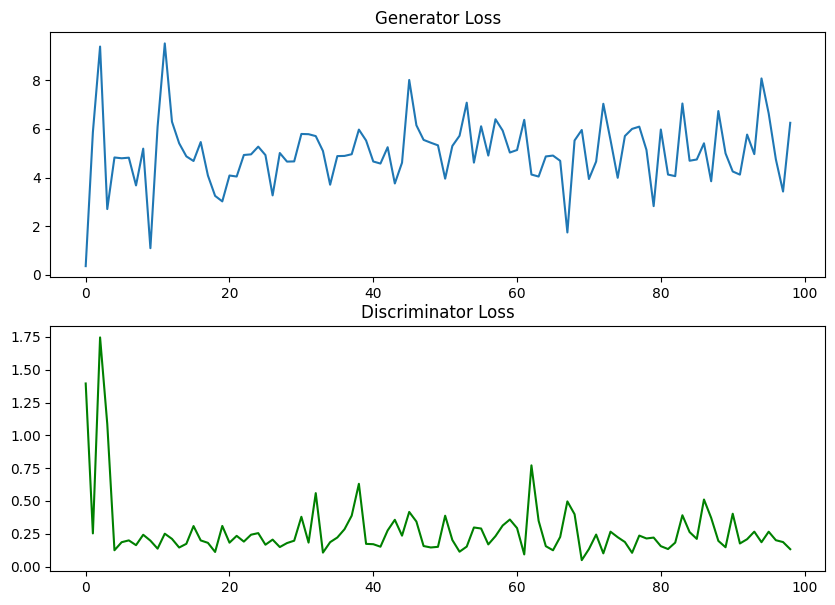

In [ ]:
report_path = "/content/drive/MyDrive/MSC/DGM/HW2_2/GAN/report/GAN_basic_full.csv"
plot_loss(report_path)

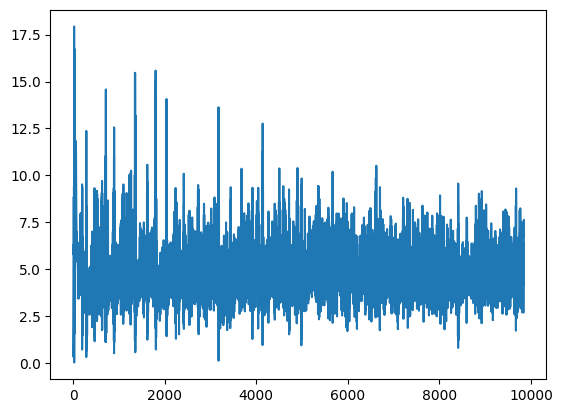

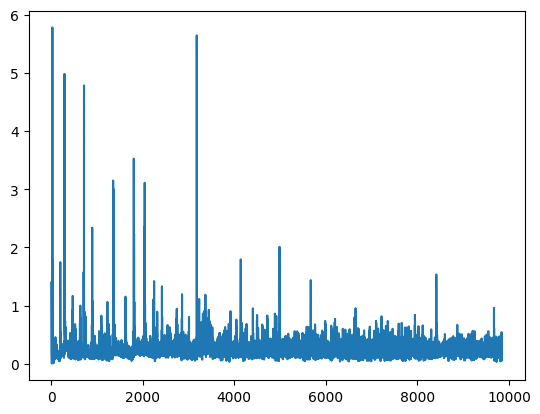

In [ ]:
plt.plot(G_loss_train)
plt.figure()
plt.plot(D_loss_train)

####WGAN

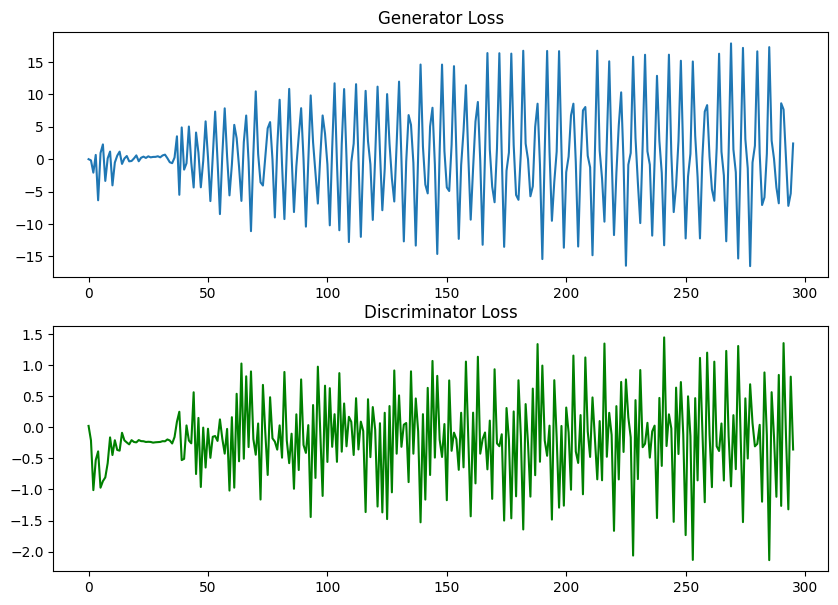

In [ ]:
report_path = "/content/drive/MyDrive/MSC/DGM/HW2_2/GAN/WGAN/report/GAN_basic_full.csv"
plot_loss(report_path)

#FID Score

Implementation of <a href=https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/> this link</a> has been used.

###install

In [ ]:
!pip install pytorch-ignite


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 1.9 MB/s eta 0:00:00


###Calculate

In [ ]:
from ignite.metrics import FID
from ignite.engine import *
import PIL.Image as Image


fid_metric = FID(device=device)
batch_size = 128
num_latents = 64


noise = torch.randn(len(test_loader.dataset), num_latents, device=device)
noise_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(noise), batch_size=batch_size)

def load_gen_model(model_path):
    model = build_model(device, num_latents=num_latents)
    optimizers = build_optimizers(model)
    states = torch.load(model_path, map_location=torch.device(device))
    return states[0]

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr).repeat(1, 3, 1, 1)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise_batch = next(noise_iter)[0]
        netG.eval()
        fake_batch = netG(noise_batch)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real


evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 63.4MB/s] 


####GAN

In [ ]:
fid_values = []


model_path = '%s/model_%04d.pt' % ("/content/drive/MyDrive/MSC/DGM/HW2_2/GAN/model", 9000)
netG = load_gen_model(model_path)
noise_iter = iter(noise_loader)
evaluator.run(test_loader,max_epochs=1)
fid = evaluator.state.metrics['fid']
print(f"*   FID : {fid:4f}")

*   FID : 0.116978


####wgan

In [ ]:
fid_values = []


model_path = '%s/model_%04d.pt' % ("/content/drive/MyDrive/MSC/DGM/HW2_2/GAN/WGAN/model", 29000)
netG = load_gen_model(model_path)
noise_iter = iter(noise_loader)
evaluator.run(test_loader,max_epochs=1)
fid = evaluator.state.metrics['fid']
print(f"*   FID : {fid:4f}")

*   FID : 0.109769


## Visualization

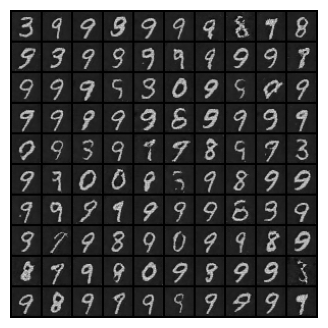

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().cpu(), (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())